In [1]:
import pandas as pd

In [2]:
ground_truth = pd.read_csv("Emotion6/ground_truth.txt",delimiter='\t')
ground_truth

,[image_filename],[valence],[arousal],[prob. anger],[prob. disgust],[prob. fear],[prob. joy],[prob. sadness],[prob. surprise],[prob. neutral]
0,disgust/1.jpg,2.5,3.8,0.133333,0.700000,0.000000,0.066667,0.100000,0.000000,0.000000
1,surprise/1.jpg,6.3,5.7,0.000000,0.066667,0.166667,0.233333,0.133333,0.233333,0.166667
2,fear/1.jpg,2.8,4.8,0.100000,0.100000,0.533333,0.000000,0.133333,0.000000,0.133333
3,joy/1.jpg,8.0,4.5,0.000000,0.000000,0.000000,0.666667,0.000000,0.266667,0.066667
4,sadness/1.jpg,2.7,5.2,0.000000,0.000000,0.100000,0.000000,0.900000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1975,joy/329.jpg,7.7,5.2,0.000000,0.000000,0.000000,0.622222,0.000000,0.222222,0.155556
1976,sadness/329.jpg,4.2,4.6,0.083333,0.072222,0.322222,0.066667,0.305556,0.016667,0.133333
1977,disgust/330.jpg,4.1,5.0,0.022222,0.355556,0.166667,0.000000,0.100000,0.022222,0.333333
1978,joy/330.jpg,7.3,5.2,0.000000,0.000000,0.000000,0.722222,0.000000,0.122222,0.155556


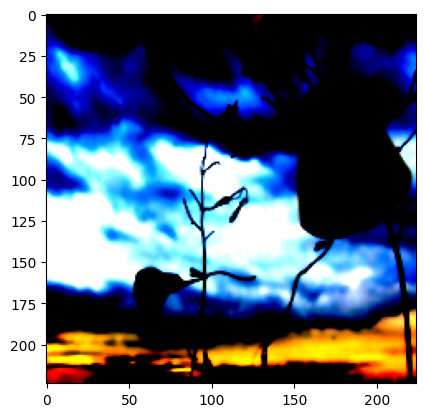

Label: tensor(2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resnet input size
    # transforms.RandomHorizontalFlip(p=0.5),        
    # transforms.RandomRotation(15),                 
    # transforms.ColorJitter(brightness=0.2,         
    #                        contrast=0.2,
    #                        saturation=0.2,
    #                        hue=0.1),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalization
])


root_dir = 'Emotion6/images'  


dataset = datasets.ImageFolder(root=root_dir,transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


images, labels = next(iter(dataloader))

plt.imshow(images[0].permute(1, 2, 0))  # dim changed for visualization
plt.show()

print('Label:', labels[0])

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size




In [ ]:
model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


num_ftrs = model.fc.in_features  
num_classes = 6  


model.fc = nn.Sequential(
    # nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, num_classes)  
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Optimizing only the new fully connected layer


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the image to 224x224 (ResNet input size)
#     transforms.RandomHorizontalFlip(p=0.5),        # Randomly flip images horizontally
#     transforms.RandomRotation(15),                 # Randomly rotate images by up to 15 degrees
#     transforms.ColorJitter(brightness=0.2,         # Randomly adjust brightness, contrast, saturation, and hue
#                            contrast=0.2,
#                            saturation=0.2,
#                            hue=0.1),
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
# ])


cuda:0


In [ ]:

import logging
logging.basicConfig(filename='runs/resnet18_batch64.txt', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

num_epochs = 100  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        # grad clip added
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    logging.info(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')
    save_path = 'image_classifier_models/model_epoch_{}.pth'
    torch.save(model.state_dict(), save_path.format(epoch+1))





Epoch 1/100 | Loss: 1.5663 | Accuracy: 0.3783
Epoch 2/100 | Loss: 1.2771 | Accuracy: 0.5192
Epoch 3/100 | Loss: 1.1951 | Accuracy: 0.5475
Epoch 4/100 | Loss: 1.1403 | Accuracy: 0.5848
Epoch 5/100 | Loss: 1.0792 | Accuracy: 0.5985
Epoch 6/100 | Loss: 1.0447 | Accuracy: 0.6273
Epoch 7/100 | Loss: 1.0221 | Accuracy: 0.6152
Epoch 8/100 | Loss: 1.0283 | Accuracy: 0.6157
Epoch 9/100 | Loss: 0.9889 | Accuracy: 0.6278
Epoch 10/100 | Loss: 0.9662 | Accuracy: 0.6364
Epoch 11/100 | Loss: 0.9616 | Accuracy: 0.6404
Epoch 12/100 | Loss: 0.9576 | Accuracy: 0.6576
Epoch 13/100 | Loss: 0.9663 | Accuracy: 0.6379
Epoch 14/100 | Loss: 0.9256 | Accuracy: 0.6581
Epoch 15/100 | Loss: 0.9398 | Accuracy: 0.6535
Epoch 16/100 | Loss: 0.9180 | Accuracy: 0.6687
Epoch 17/100 | Loss: 0.9032 | Accuracy: 0.6742
Epoch 18/100 | Loss: 0.9065 | Accuracy: 0.6682
Epoch 19/100 | Loss: 0.8945 | Accuracy: 0.6742
Epoch 20/100 | Loss: 0.8701 | Accuracy: 0.6803
Epoch 21/100 | Loss: 0.8951 | Accuracy: 0.6662
Epoch 22/100 | Loss: 0

In [73]:
model.load_state_dict(torch.load('image_classifier_models/model_epoch_100.pth'))
model.eval()
val_loss = 0.0
val_correct_top1 = 0
val_correct_top2 = 0
val_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct_top1 += (predicted == labels).sum().item()

        _, top2_preds = torch.topk(outputs, 2, dim=1)
        val_correct_top2 += sum([labels[i] in top2_preds[i] for i in range(labels.size(0))])

print(f"Validation Accuracy: {100 * val_correct_top1 / val_total}%")
print(f"Validation Accuracy (Top-2): {100 * val_correct_top2 / val_total}%")
print(val_loss)

Validation Accuracy: 84.17508417508418%
Validation Accuracy (Top-2): 92.92929292929293%
5.457939654588699


predict image emotion with prob

In [81]:
import torch
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F



# Function to predict the probabilities for a given image
def predict_image(image_path):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    model.load_state_dict(torch.load('image_classifier_models/model_epoch_100.pth'))
    model.eval()  
    image = Image.open(image_path)

    image = transform(image).unsqueeze(0).to(device)  
    

    with torch.no_grad():
        outputs = model(image)

    probabilities = F.softmax(outputs, dim=1)  # np array of probs 
    return probabilities.squeeze(0).cpu().numpy()

# Example usage:
image_path = 'Emotion6/images/surprise/115.jpg'  
probabilities = predict_image(image_path)

# Print the probabilities for each class
print("Class Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.2f}")



Class Probabilities:
Class 0: 0.01
Class 1: 0.04
Class 2: 0.03
Class 3: 0.24
Class 4: 0.00
Class 5: 0.68
